In [61]:
import numpy as np
import pandas as pd
import scipy
from glob import glob
import matplotlib.pyplot as plt
from skimage import transform
from imageio import imread

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import datetime
import sys
import os
!pip install imageio

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving input.zip to input.zip


In [ ]:
!unzip input.zip

Archive:  input.zip
   creating: input/
   creating: input/cityscapes/
   creating: input/cityscapes/cityscapes/
   creating: input/cityscapes/cityscapes/train/
  inflating: input/cityscapes/cityscapes/train/1.jpg  
  inflating: input/cityscapes/cityscapes/train/10.jpg  
  inflating: input/cityscapes/cityscapes/train/100.jpg  
  inflating: input/cityscapes/cityscapes/train/101.jpg  
  inflating: input/cityscapes/cityscapes/train/102.jpg  
  inflating: input/cityscapes/cityscapes/train/103.jpg  
  inflating: input/cityscapes/cityscapes/train/104.jpg  
  inflating: input/cityscapes/cityscapes/train/105.jpg  
  inflating: input/cityscapes/cityscapes/train/106.jpg  
  inflating: input/cityscapes/cityscapes/train/107.jpg  
  inflating: input/cityscapes/cityscapes/train/108.jpg  
  inflating: input/cityscapes/cityscapes/train/109.jpg  
  inflating: input/cityscapes/cityscapes/train/11.jpg  
  inflating: input/cityscapes/cityscapes/train/110.jpg  
  inflating: input/cityscapes/cityscapes/trai

In [ ]:
!ls

input  input.zip  sample_data


In [ ]:
if os.path.exists("/content/input"):
    print(os.listdir("/content/input"))
else:
    print("No input directory found. Please ensure your data is in the correct path.")

['edges2shoes', 'cityscapes', 'maps', 'facades']


In [52]:
def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('/content/input/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)
        img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :]
            else:
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)


        imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [53]:
def load_batch( dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('/content/input/%s/%s/%s/*' % (dataset_name,dataset_name, data_type))


        n_batches=batch_size
        img_res=(128,128)
        for i in range(n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :]
                else:
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image

 # when training => do random flip , this is a trick to avoid overfitting
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [54]:
def build_generator(img_shape, gf=64, channels=3):
    """U-Net Generator"""

    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])  # skip connection
        return u

    d0 = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf * 2)
    d3 = conv2d(d2, gf * 4)
    d4 = conv2d(d3, gf * 8)
    d5 = conv2d(d4, gf * 8)
    d6 = conv2d(d5, gf * 8)
    d7 = conv2d(d6, gf * 8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf * 8)
    u2 = deconv2d(u1, d5, gf * 8)
    u3 = deconv2d(u2, d4, gf * 8)
    u4 = deconv2d(u3, d3, gf * 4)
    u5 = deconv2d(u4, d2, gf * 2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(d0, output_img)

In [55]:
def build_discriminator(img_shape, df=64):
    """Discriminator model"""

    # A small function to make one layer of the discriminator
    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)

    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df * 2)
    d3 = d_layer(d2, df * 4)
    d4 = d_layer(d3, df * 8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([img_A, img_B], validity)

In [56]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

# Calculate output shape of D (PatchGAN)
patch = img_rows // 16  # Equivalent to int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64  # Generator filters
df = 64  # Discriminator filters

# Optimizer
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape, df)
discriminator.compile(loss='mse',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the generator
generator = build_generator(img_shape, gf)

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model, we will only train the generator
discriminator.trainable = False

# Discriminator determines the validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

# Combined model
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                 loss_weights=[1, 100],
                 optimizer=optimizer)

In [57]:
def show_images( dataset_name,epoch, batch_i):

        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,batch_size=3, is_val=True)
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [58]:
def train(dataset_name, epochs, batch_size=1, show_interval=10):
    start_time = datetime.datetime.now()

    # Adversarial loss ground truths
    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)

    for epoch in range(epochs):
        batch_i = 0  # Initialize batch_i to ensure it is defined
        for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name, batch_size)):
            # Initialize d_loss to prevent UnboundLocalError
            d_loss = None  # Initialize to ensure it's defined before use

            try:
                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                # Calculate elapsed time after each batch
                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % 10 == 0:  # Change to batch_i for more frequent updates
                    if d_loss is not None:  # Check if d_loss was calculated
                        print("[Epoch %d/%d, Batch %d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" %
                              (epoch, epochs, batch_i,
                               d_loss[0], 100 * d_loss[1],
                               g_loss[0],
                               elapsed_time))
            except Exception as e:
                print(f"Error during training: {e}")
                continue  # Skip to the next batch/epoch

        # If at show interval => show generated image samples
        if epoch % show_interval == 0 and batch_i > 0:  # Ensure there was at least one batch processed
            show_images(dataset_name, epoch, batch_i)

<ipython-input-53-1043763db043>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[Epoch 0/50, Batch 0]  [D loss: 0.691299, acc:  25%] [G loss: 0.462109] time: 0:01:08.624325
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Error during training: Dimensions must be equal, but are 32 and 12 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](Cast_1, Cast_3)' with input shapes: [32,8,8,1], [12,8,8,1].
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error
Error during training: math domain error


<ipython-input-52-d8ed22a02706>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


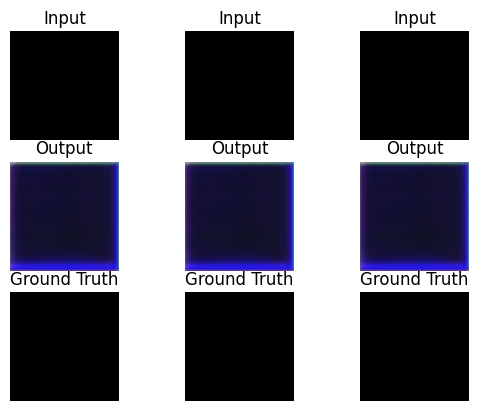

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[Epoch 1/50, Batch 0]  [D loss: 0.474118, acc:  48%] [G loss: 0.462043] time: 0:09:23.435960
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
train("cityscapes",epochs=50, batch_size=32, show_interval=10)